# Philippine Household Income
## Project Duration: March 15, 2021 to March 26, 2021
### Group Life 4
**Authors**: Princess Eramie Arenas, Carl Cordova, Diane Isabelle Lambojo, Penelope Joice Lapiz, and Cary Legaspi
<br> <br>
Life is a gift and we need to live it fully, for we only have one shot at life. In life, we are given the chance to go through different challenges and both ups and downs. but we learn & grow as we experience them.

In order to keep living, we need safety, security, and well-being. This is where our **income** comes in. By having a source of income, we may make ends meet and survive with our daily living, acquiring safety, security, & well-being, and being able to provide for our families with their daily needs. Although we can say that this is just the bare minimum about income, it is safe to say that having an income source is very important.

This project aims to **predict the total household income of a family in the Philippines through linear regression analysis, random forest regressor analysis, and random forest classifier**, with the help of multiple predictor variables. We deem to know which factors affect the amount of total household income of a household in the country, including but not limited to, whether or not families living in the same region are receiving the same range of amount of income.

There are two datasets used for this project. The first one is **Filipino Family Income and Expenditure** which contains data of the annual household income and expenses in the Philippines from 2018, gathered by the Philippine Statistics Authority (PSA) who spearheads the conduct of the Family Income and Expenditure Survey (FIES) nationwide every three (3) years, and can be found [here](https://www.kaggle.com/grosvenpaul/family-income-and-expenditure), and the second is **TESDA (Technical Education and Skills Development Authority) Institutions** which contains a list of technical vocational institutions with TESDA registered programs from 2017, and can be found [here](https://data.gov.ph/?q=dataset/list-technical-vocational-institutions-tesda-registered-programs). We included the TESDA dataset because **TESDA claims and is at the same time known to make technical education more accessible to Filipino citizens, and we want to know if there is correlation between the income of a household in the Philippines and the availability of TESDA accredited institutions in their regions.**

**There is a total of 23 variables in this analysis** which will be presented later on below.

This Data Analytics project is created for the completion of the course IT465 or Data Analytics 2 by the following group of 3rd year college students from Cebu Institute of Technology - University: Princess Eramie Arenas, Carl Cordova, Diane Isabelle Lambojo, Penelope Joice Lapiz, and Cary Legaspi.

### Importing Libraries

We will be using different libraries from python that will help us answer what factors affect a Filipino household's income, so the first step is to import these libraries. For data visualization, we use the matplotlib and seaborn libraries while in building the model, we use sklearn which is now known as scikit-learn and evaluate it using the statsmodels library.

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, plot_confusion_matrix


from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

import math
from sklearn.tree import export_graphviz
import pydot

from sklearn.metrics import accuracy_score
from IPython.display import Image

### Defining Functions

The following functions are created for:
<br><BLOCKQUOTE>1) extracting useful data for this analysis from the TESDA dataset,<br>
2) formatting the region names from the said dataset for uniform naming convention,<br>
3) data cleaning,<br>
4) formatting categorical column names, and<br>
5) encoding categorical columns
</BLOCKQUOTE>
which we will each be calling in the later part of this project.


In [70]:
def extract_tesda_data():
    tesda_df = pd.read_csv('tesda_institutions.csv')
    tesda_df = tesda_df.drop_duplicates(subset='name_of_institution')
    tesda_df = tesda_df.region.value_counts().reset_index(name='tesda_accredited_institutions')
    tesda_df = tesda_df.rename(columns={'index':'region'})
    return tesda_df

def format_regions(income_df):
    income_df['region'] = income_df['region'].replace('Caraga', 'CARAGA')
    income_df['region'] = income_df['region'].replace('VI - Western Visayas', 'VI')
    income_df['region'] = income_df['region'].replace('V - Bicol Region', 'V')
    income_df['region'] = income_df['region'].replace(' ARMM', 'ARMM')
    income_df['region'] = income_df['region'].replace('III - Central Luzon', 'III')
    income_df['region'] = income_df['region'].replace('II - Cagayan Valley', 'II')
    income_df['region'] = income_df['region'].replace('IVA - CALABARZON', 'IV-A')
    income_df['region'] = income_df['region'].replace('VII - Central Visayas', 'VII')
    income_df['region'] = income_df['region'].replace('X - Northern Mindanao', 'X')
    income_df['region'] = income_df['region'].replace('XI - Davao Region', 'XI')
    income_df['region'] = income_df['region'].replace('VIII - Eastern Visayas', 'VIII')
    income_df['region'] = income_df['region'].replace('I - Ilocos Region', 'I')
    income_df['region'] = income_df['region'].replace('IVB - MIMAROPA', 'IV-B')
    income_df['region'] = income_df['region'].replace('XII - SOCCSKSARGEN', 'XII')
    income_df['region'] = income_df['region'].replace('IX - Zasmboanga Peninsula', 'IX')
    return income_df

def check_null(income_df):
    income_df = income_df.isna().sum()
    return income_df

def replace_nan(income_df):
    income_df = income_df.replace('..','nan')
    income_df.sample(10)
    return income_df

def replace_inf(income_df):
    income_df = income_df.replace([np.inf, -np.inf], np.nan).dropna(how="all")
    return income_df

def check_dupes(income_df):
    income_df = income_df.duplicated()
    return income_df

def check_shape(income_df):
    income_df = income_df.shape
    return income_df

def format_categorical_columns(income_df):
    #main income source column
    income_df['main_income_source'] = income_df['main_income_source'].replace('Wage/Salaries', 'wage_salaries')
    income_df['main_income_source'] = income_df['main_income_source'].replace('Other sources of Income', 'other_source_of_income')
    income_df['main_income_source'] = income_df['main_income_source'].replace('Enterpreneurial Activities', 'entrep_activities')
    #house hold sex column
    income_df['house_hold_sex'] = income_df['house_hold_sex'].replace('Female', 'female')
    income_df['house_hold_sex'] = income_df['house_hold_sex'].replace('Male', 'male')
    #househould head marital status column
    income_df['house_hold_head_marital_status'] = income_df['house_hold_head_marital_status'].replace('Single', 'single')
    income_df['house_hold_head_marital_status'] = income_df['house_hold_head_marital_status'].replace('Married', 'married')
    income_df['house_hold_head_marital_status'] = income_df['house_hold_head_marital_status'].replace('Widowed', 'widowed')
    income_df['house_hold_head_marital_status'] = income_df['house_hold_head_marital_status'].replace('Divorced/Separated', 'divorced_separated')
    income_df['house_hold_head_marital_status'] = income_df['house_hold_head_marital_status'].replace('Annulled', 'annulled')
    income_df['house_hold_head_marital_status'] = income_df['house_hold_head_marital_status'].replace('Unknown', 'unknown')
    #househould head job/business indicator column
    income_df['household_head_job_business_indicator'] = income_df['household_head_job_business_indicator'].replace('With Job/Business', 'with_job_business')
    income_df['household_head_job_business_indicator'] = income_df['household_head_job_business_indicator'].replace('No Job/Business', 'no_job_business')
    #househould type column
    income_df['type_of_household'] = income_df['type_of_household'].replace('Extended Family', 'extended_fam')
    income_df['type_of_household'] = income_df['type_of_household'].replace('Single Family', 'single_fam')
    income_df['type_of_household'] = income_df['type_of_household'].replace('Two or More Nonrelated Persons/Members', 'two_more_nonrelated')
    #househould head worker class column
    income_df['household_head_worker_class'] = income_df['household_head_worker_class'].replace('Worked for government/government corporation', 'worked_for_govt')
    income_df['household_head_worker_class'] = income_df['household_head_worker_class'].replace('Worked for private establishment', 'worked_for_private')
    income_df['household_head_worker_class'] = income_df['household_head_worker_class'].replace('Employer in own family-operated farm or business', 'employer_in_own_fam_business')
    income_df['household_head_worker_class'] = income_df['household_head_worker_class'].replace('Self-employed wihout any employee', 'self_employed_without_employee')
    income_df['household_head_worker_class'] = income_df['household_head_worker_class'].replace('Worked without pay in own family-operated farm or business', 'without_pay_in_own_business')
    income_df['household_head_worker_class'] = income_df['household_head_worker_class'].replace('Worked for private household', 'worked_for_private_household')
    income_df['household_head_worker_class'] = income_df['household_head_worker_class'].replace('Worked with pay in own family-operated farm or business', 'with_pay_in_own_business')
    #tenure status column
    income_df['tenure_status'] = income_df['tenure_status'].replace('Own or owner-like possession of house and lot', 'owner_house_and_lot')
    income_df['tenure_status'] = income_df['tenure_status'].replace('Rent-free house and lot with consent of owner', 'rent_free_house_lot_with_consent')
    income_df['tenure_status'] = income_df['tenure_status'].replace('Own house, rent-free lot with consent of owner', 'own_house_rent_free_lot_with_consent')
    income_df['tenure_status'] = income_df['tenure_status'].replace('Own house, rent-free lot without consent of owner', 'own_house_rent_free_lot_without_consent')
    income_df['tenure_status'] = income_df['tenure_status'].replace('Rent-free house and lot without consent of owner', 'rent_free_house_lot_without_consent')
    income_df['tenure_status'] = income_df['tenure_status'].replace('Rent house/room including lot', 'rent_house_with_lot')
    income_df['tenure_status'] = income_df['tenure_status'].replace('Not Applicable', 'not_applicable')
    income_df['tenure_status'] = income_df['tenure_status'].replace('Own house, rent lot', 'own_house_rent_lot')
    
    return income_df

def encoded_categorical_columns(income_df):
    #one hot encoding
    encoded_income_df = pd.get_dummies(income_df, columns = categorical_columns, prefix = categorical_prefixes, drop_first=True)
    #drop_first=True Remove first level to get k-1 dummies out of k categorical levels. It helps in reducing the extra column created during dummy variable creation. 
    return encoded_income_df

def describe_dataframe(df):
    # get the summary
    desc_df = df.describe()

    # add the standard deviation metric
    desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
    desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

    # display it
    return desc_df

def plot_heatmap(df):
    corr = df.corr()
    # Make figure size larger
    sns.set(rc={'figure.figsize':(11.7,8.27)})

    # using seaborn to plot the correlation heatmap
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')
    
def get_VFI_score(df, columns):
    # the VFI does expect a constant term in the data, so we need to add one using the add_constant method
    X1 = sm.tools.add_constant(df)

    # create the series for before
    columns_vfi_df = pd.DataFrame([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index=X1.columns)

    columns_to_drop = []
    for index,score in enumerate(columns_vfi_df.iloc[1:][0]):
        if score > 5:
            print(f'{columns[index]} VFI score: {score}')
            columns_to_drop.append(columns[index])
    return columns_to_drop, columns_vfi_df

def print_score(model_name, model, x_train, x_test, y_train, y_test):
    print(model_name)
    print("Train R-Squared: ", model.score(x_train, y_train))
    print("Test R-Squared: ", model.score(x_test, y_test))
    
def print_errors(model_name, pred, true):
    print(model_name)
    e = mean_squared_error(pred, true)
    print("Mean Squared Error (MSE): ", e)
    print("Mean Absolute Error (MAE): ", mean_absolute_error(pred, true))
    print("Root Mean Squared Error (RMSE): ", math.sqrt(e))
    print()

def visualize_tree(tree,filename,X, class_names=None):
    # Save the tree as a png image
    export_graphviz(tree, out_file = f'{filename}.dot', feature_names = X.columns, rounded = True, class_names=class_names, precision = 1)
    (graph, ) = pydot.graph_from_dot_file(f'{filename}.dot')
    graph.write_png(f'{filename}.png');
    
def print_important_variables(model,X):
    importances = model.feature_importances_.tolist()
    # List of tuples with variable and importance
    feature_importances = [(X, round(importance, 2)) for X, importance in zip(X.columns, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('{:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    
def get_good_sample_randomization(model,df):
    random_state = 1
    X,Y,x_train, x_test, y_train, y_test = train_test_split_sampling(random_state,df)

    model.fit(x_train, y_train.values.flatten())
    max_train_score = model.score(x_train, y_train)
    max_test_score = model.score(x_test, y_test)
    print('initial:')
    print('train score: ',max_train_score,'\n','test score: ',max_test_score)
    for i in range(1,100):
        X,Y,x_train, x_test, y_train, y_test = train_test_split_sampling(i,df)
        model.fit(x_train, y_train.values.flatten())
        train_score = model.score(x_train, y_train)
        test_score = model.score(x_test, y_test)
        if (train_score > 0.80 and test_score > 0.80) and (train_score > max_train_score or test_score > max_test_score):
            max_test_score = test_score
            max_train_score = train_score
            print('Good random state:',i)
            print(max_test_score,max_train_score)
            random_state = i
    return random_state

def train_test_split_sampling(random_state, df):
    sampled_income_df = df.sample(n=int(len(encoded_income_df.index)/2),random_state=random_state)

    X = sampled_income_df.drop(['total_household_income'], axis = 1)
    Y = sampled_income_df[['total_household_income']]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1)
    return X, Y, x_train, x_test, y_train, y_test

## Preparing the Dataset

Note that not all data from the dataset will be used for we will be choosing the data which we find important in this analysis, and below is the code showing the extraction of useful data for the prediction of income from the tesda institutions dataset. We decided that in order to improve the r-squared score of our models, we will add another column to the income and expenditure dataset using the number of TESDA accreddited institutions per region.

In [71]:
#Load datasets
tesda_df = extract_tesda_data()
income_df = pd.read_csv('family_income_expenditure.csv')

### Cleaning the TESDA dataframe Income and Expenditure dataframe's region column for merging
The column containing the regions from the **TESDA** dataset is extracted and since some region values has space, it will be replaced for uniformity purposes. On the other hand, the naming convention of the regions of the **Filipino Family Income and Expenditure** dataset is not exactly the same as that of the TESDA dataset. So we will call format regions to uniformize the region values, for these two dataframes will be merged into one column, in this case the column **region**, once the region values are cleaned.
<br><br>
The column tesda_accredited_institutions will be added to income_df.

In [72]:
#format the region to be the same with tesda region column so that they can be merged
format_regions(income_df)
tesda_df['region'] = tesda_df['region'].replace('IX ', 'IX')
print(sorted(income_df.region.unique()))
print(sorted(tesda_df.region.unique()))

['ARMM', 'CAR', 'CARAGA', 'I', 'II', 'III', 'IV-A', 'IV-B', 'IX', 'NCR', 'V', 'VI', 'VII', 'VIII', 'X', 'XI', 'XII']
['ARMM', 'CAR', 'CARAGA', 'I', 'II', 'III', 'IV-A', 'IV-B', 'IX', 'NCR', 'V', 'VI', 'VII', 'VIII', 'X', 'XI', 'XII']


All is good, we will now **merge** both dataframes.

In [73]:
#merge tesda and income_expenditure df
income_df = pd.merge(income_df, tesda_df, on='region')

## Exploring the Dataset

To explore the dataset, we will create a scatter plot diagram. Since the dataset has 60 columns, we will only select columns that have possible correlation with total household income based on the scatterplot and is considered as interesting when interpreted based on the models for the dataset.

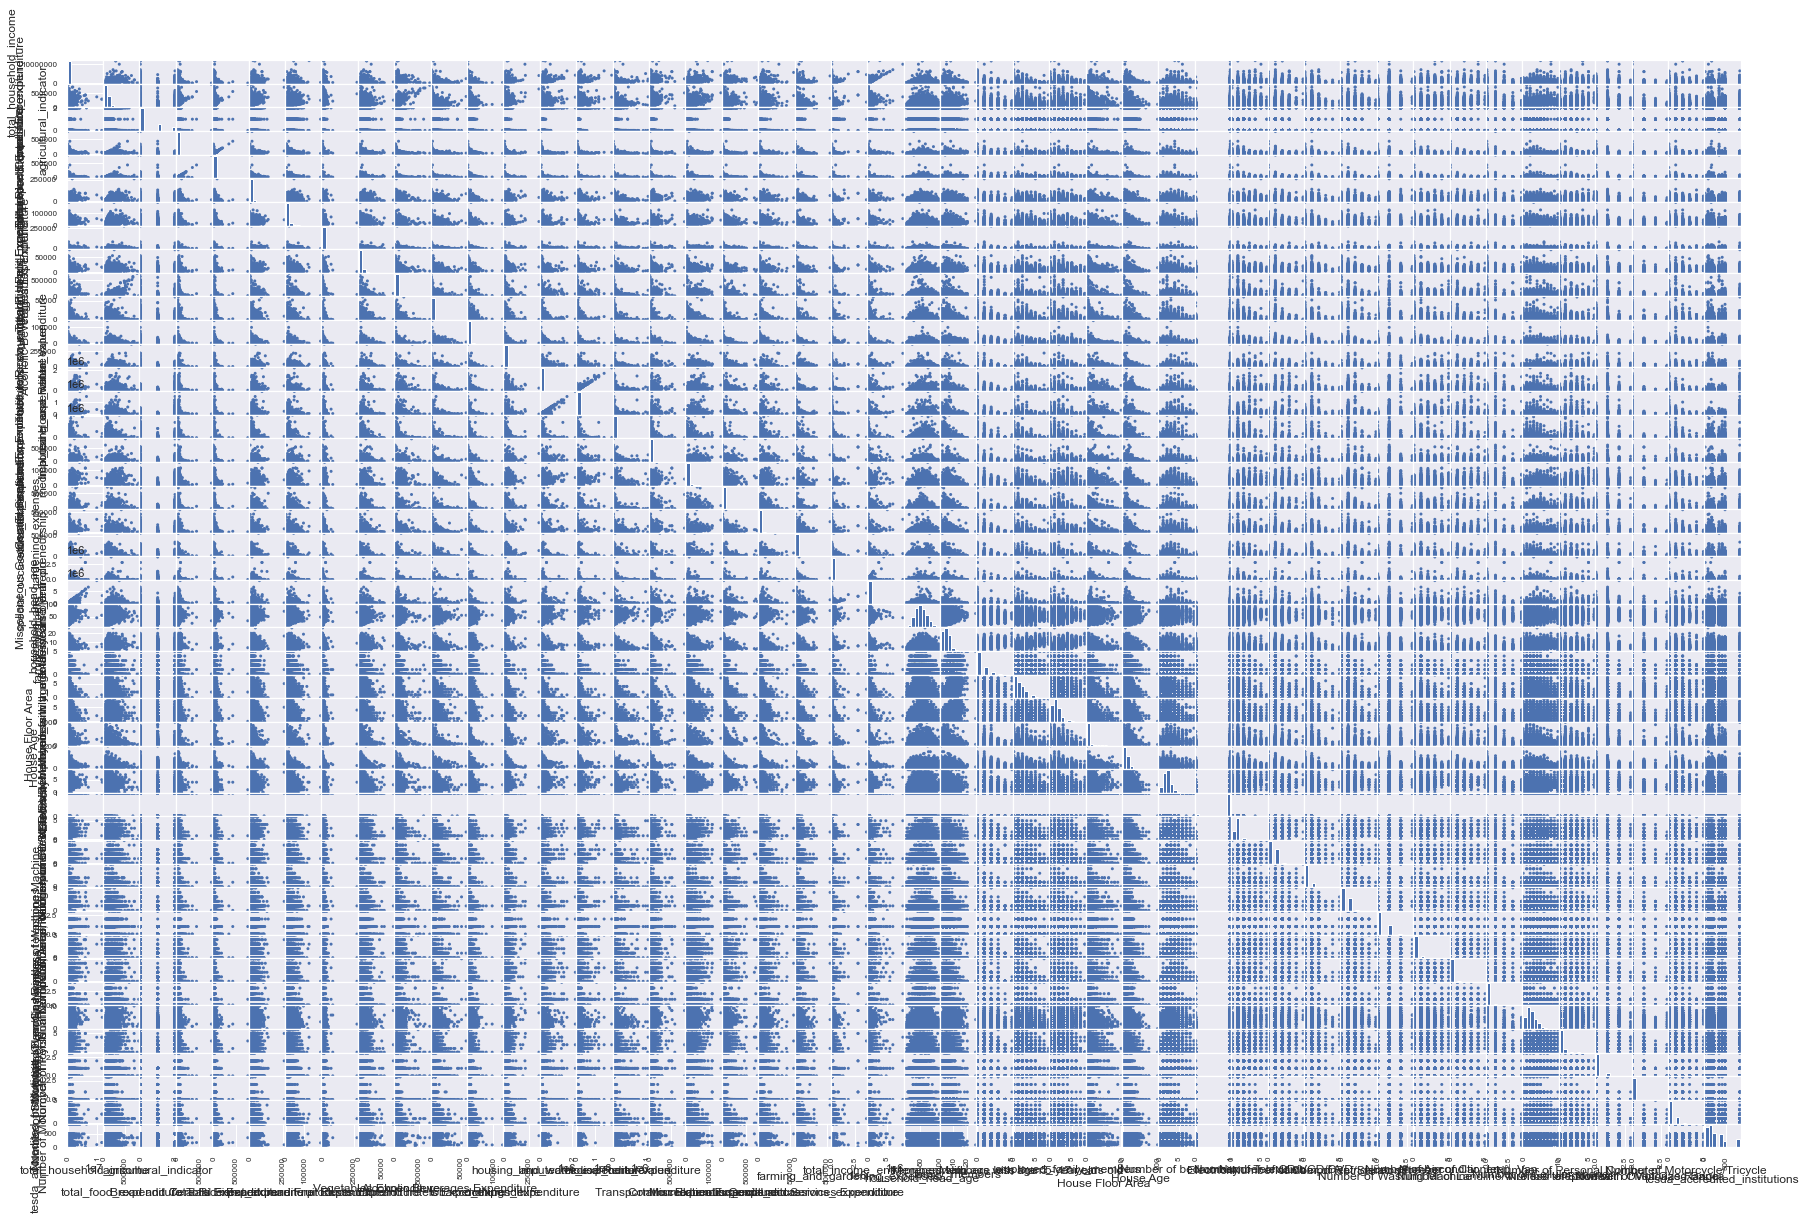

In [74]:
pd.plotting.scatter_matrix(income_df, alpha = 1, figsize = (30, 20))
plt.show()

## Variables

Based on the scatterplot and judgment of the authors, the following are the variables used for this project:<br><br>
**y = total_household_income** - the total annual income the household earns <br>
**x1 = region** - the location of the household <br>
**x2 = total_food_expenditure** - the total expense a household spends for food consumption <br>
**x3 = main_income_source** - the household's main source of income <br>
**x4 = agricultural_indicator** - the measure of net value added from agriculture over years<br>
**x5 = special_occassions_expenditure** - the total expense a household spends for special occasions<br>
**x6 = farming_and_gardening_expenses** - the total expense a household spends for farming and gardening<br>
**x7 = tobacco_expenditure** - the total expense a household spends for tobacco usage<br>
**x8 = clothings_expenditure** - the total expense a household spends for clothing <br>
**x9 = housing_and_water_expenditure** - the total expense a household spends for housing and water bills <br>
**x10 = medical_care_expenditure** - the total expense a household spends for health/medical care<br>
**x11 = education_expenditure** - the total expense a household spends for education <br>
**x12 = house_hold_sex** - the gender of the household head <br>
**x13 = household_head_age** - the age of the household head <br>
**x14 = house_hold_head_marital_status** - the marital status of the household head <br>
**x15 = household_head_job_business_indicator** - the identification whether the household head has a job or a business <br>
**x16 = type_of_household** - the type of family/families living in a household <br>
**x17 = family_members** - the total number of family members in a household <br>
**x18 = employed_family_members** - the total number of employed family members in a household <br>
**x19 = total_income_entrepreneurship** - the total income a household earned from entrepreneurship<br>
**x20 = household_head_worker_class** - the work class of the household head<br>
**x21 = tenure_status** - the tenure status of the household head<br>
**x22 = tesda_accredited_institutions** - the total number of tesda accredited institutions per region <br>

In [75]:
#columns that will be used
column_names = [
    'total_household_income',
    'region',
    'total_food_expenditure',
    'main_income_source',
    'agricultural_indicator',
    'special_occassions_expenditure',
    'farming_and_gardening_expenses',
    'tobacco_expenditure',
    'clothings_expenditure',
    'housing_and_water_expenditure',
    'medical_care_expenditure',
    'education_expenditure',
    'house_hold_sex',
    'household_head_age',
    'house_hold_head_marital_status',
    'household_head_job_business_indicator',
    'type_of_household',
    'family_members',
    'employed_family_members',
    'total_income_entrepreneurship',
    'household_head_worker_class',
    'tenure_status',
    'tesda_accredited_institutions', 
]
#identifying categorical columns for encoding
categorical_columns = [
    'region',
    'main_income_source',
    'house_hold_sex',
    'house_hold_head_marital_status',
    'household_head_job_business_indicator',
    'type_of_household',
    'household_head_worker_class',
    'tenure_status',
]
categorical_prefixes = [
    'region',
    'income_source',
    'head_sex',
    'head',
    'head_indicator',
    'household_type',
    'worker_class',
    'tenure'
]

In [76]:
### Selecting the Columns
income_df = income_df[column_names]

### Removing Outliers
After several runs, we identified that removing the outliers would give lower r-squared values in the model, but gives higher values in measurement of errors. Since r-squared of 80% is a requirement for this project, we decided to **skip removing the outliers**

## Data Cleaning

**In cleaning the data, the functions check_null, replace_nan, replace_inf, check_dupes, and check_shape were called**  
<br><BLOCKQUOTE>to print if there are null values which as seen below, there are none,
<br>to replace rows and columns with values that are not a number with nan,
<br>to drop infinity values,
<br>to check for duplicates, and
<br>to check how many rows are left after the cleaning process respectively.</BLOCKQUOTE>
<br>Data cleaning is a very important step in this analysis in order to get accurate results.

In [77]:
#checking for nulls
check_null(income_df)

total_household_income                      0
region                                      0
total_food_expenditure                      0
main_income_source                          0
agricultural_indicator                      0
special_occassions_expenditure              0
farming_and_gardening_expenses              0
tobacco_expenditure                         0
clothings_expenditure                       0
housing_and_water_expenditure               0
medical_care_expenditure                    0
education_expenditure                       0
house_hold_sex                              0
household_head_age                          0
house_hold_head_marital_status              0
household_head_job_business_indicator       0
type_of_household                           0
family_members                              0
employed_family_members                     0
total_income_entrepreneurship               0
household_head_worker_class              7783
tenure_status                     

In [78]:
income_df = income_df.dropna()

In [79]:
check_null(income_df)

total_household_income                   0
region                                   0
total_food_expenditure                   0
main_income_source                       0
agricultural_indicator                   0
special_occassions_expenditure           0
farming_and_gardening_expenses           0
tobacco_expenditure                      0
clothings_expenditure                    0
housing_and_water_expenditure            0
medical_care_expenditure                 0
education_expenditure                    0
house_hold_sex                           0
household_head_age                       0
house_hold_head_marital_status           0
household_head_job_business_indicator    0
type_of_household                        0
family_members                           0
employed_family_members                  0
total_income_entrepreneurship            0
household_head_worker_class              0
tenure_status                            0
tesda_accredited_institutions            0
dtype: int6

In [80]:
#replacing nan values
replace_nan(income_df)

,total_household_income,region,total_food_expenditure,main_income_source,agricultural_indicator,special_occassions_expenditure,farming_and_gardening_expenses,tobacco_expenditure,clothings_expenditure,housing_and_water_expenditure,...,household_head_age,house_hold_head_marital_status,household_head_job_business_indicator,type_of_household,family_members,employed_family_members,total_income_entrepreneurship,household_head_worker_class,tenure_status,tesda_accredited_institutions
0,480332,CAR,117848,Wage/Salaries,0,7200,19370,0,4607,63636,...,49,Single,With Job/Business,Extended Family,4,1,44370,Worked for government/government corporation,Own or owner-like possession of house and lot,100
1,198235,CAR,67766,Wage/Salaries,0,1500,0,2132,8230,41370,...,40,Married,With Job/Business,Single Family,3,2,0,Worked for private establishment,Own or owner-like possession of house and lot,100
2,82785,CAR,61609,Wage/Salaries,1,500,0,4525,2735,14340,...,39,Married,With Job/Business,Single Family,6,3,0,Worked for private establishment,Own or owner-like possession of house and lot,100
3,107589,CAR,78189,Wage/Salaries,0,500,15580,0,1390,16638,...,52,Married,With Job/Business,Single Family,3,2,15580,Employer in own family-operated farm or business,Own or owner-like possession of house and lot,100
4,189322,CAR,94625,Wage/Salaries,0,1000,18887,0,4620,31122,...,65,Married,With Job/Business,Single Family,4,2,75687,Self-employed wihout any employee,Own or owner-like possession of house and lot,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43327,246510,IX,109521,Enterpreneurial Activities,2,41000,0,4810,3442,20448,...,51,Married,With Job/Business,Single Family,7,0,115100,Employer in own family-operated farm or business,"Own house, rent-free lot with consent of owner",5
43328,285300,IX,149327,Enterpreneurial Activities,2,1000,0,7800,6945,26580,...,30,Married,With Job/Business,Extended Family,12,1,195000,Self-employed wihout any employee,Own or owner-like possession of house and lot,139
43329,285300,IX,149327,Enterpreneurial Activities,2,1000,0,7800,6945,26580,...,30,Married,With Job/Business,Extended Family,12,1,195000,Self-employed wihout any employee,Own or owner-like possession of house and lot,5
43330,205590,IX,83441,Other sources of Income,2,2600,0,0,5090,29208,...,42,Single,With Job/Business,Extended Family,5,0,72500,Self-employed wihout any employee,Own or owner-like possession of house and lot,139


In [81]:
#replacing infinity values
replace_inf(income_df)

,total_household_income,region,total_food_expenditure,main_income_source,agricultural_indicator,special_occassions_expenditure,farming_and_gardening_expenses,tobacco_expenditure,clothings_expenditure,housing_and_water_expenditure,...,household_head_age,house_hold_head_marital_status,household_head_job_business_indicator,type_of_household,family_members,employed_family_members,total_income_entrepreneurship,household_head_worker_class,tenure_status,tesda_accredited_institutions
0,480332,CAR,117848,Wage/Salaries,0,7200,19370,0,4607,63636,...,49,Single,With Job/Business,Extended Family,4,1,44370,Worked for government/government corporation,Own or owner-like possession of house and lot,100
1,198235,CAR,67766,Wage/Salaries,0,1500,0,2132,8230,41370,...,40,Married,With Job/Business,Single Family,3,2,0,Worked for private establishment,Own or owner-like possession of house and lot,100
2,82785,CAR,61609,Wage/Salaries,1,500,0,4525,2735,14340,...,39,Married,With Job/Business,Single Family,6,3,0,Worked for private establishment,Own or owner-like possession of house and lot,100
3,107589,CAR,78189,Wage/Salaries,0,500,15580,0,1390,16638,...,52,Married,With Job/Business,Single Family,3,2,15580,Employer in own family-operated farm or business,Own or owner-like possession of house and lot,100
4,189322,CAR,94625,Wage/Salaries,0,1000,18887,0,4620,31122,...,65,Married,With Job/Business,Single Family,4,2,75687,Self-employed wihout any employee,Own or owner-like possession of house and lot,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43327,246510,IX,109521,Enterpreneurial Activities,2,41000,0,4810,3442,20448,...,51,Married,With Job/Business,Single Family,7,0,115100,Employer in own family-operated farm or business,"Own house, rent-free lot with consent of owner",5
43328,285300,IX,149327,Enterpreneurial Activities,2,1000,0,7800,6945,26580,...,30,Married,With Job/Business,Extended Family,12,1,195000,Self-employed wihout any employee,Own or owner-like possession of house and lot,139
43329,285300,IX,149327,Enterpreneurial Activities,2,1000,0,7800,6945,26580,...,30,Married,With Job/Business,Extended Family,12,1,195000,Self-employed wihout any employee,Own or owner-like possession of house and lot,5
43330,205590,IX,83441,Other sources of Income,2,2600,0,0,5090,29208,...,42,Single,With Job/Business,Extended Family,5,0,72500,Self-employed wihout any employee,Own or owner-like possession of house and lot,139


In [82]:
#checking for duplicates
check_dupes(income_df)

0        False
1        False
2        False
3        False
4        False
         ...  
43327    False
43328    False
43329    False
43330    False
43331    False
Length: 35549, dtype: bool

In [83]:
check_dupes(income_df).sum()

0

In [84]:
#checking shape
check_shape(income_df)

(35549, 23)

### Encoding the Categorical Variables
In order for the different algorithms that will be used in the following section to **run without errors**, we will need to deal with the string values. To do this, we decided to use one hot encoding technique.<br><br>
**One hot encoding** is a process by which categorical variables are converted into a form that could be provided to machine learning algorithms which helps in doing a better job at prediction.

#### Loop through all categorical columns and display the unique values
Displayed below are the unique values for each categorical column which will be converted to an integer representation using the one hot encoding technique.

In [85]:
for col in income_df:
    if col in categorical_columns:
        list = income_df[col].unique()
        list = pd.DataFrame(income_df[col], columns=[list])
        display(col,list)

'region'

,CAR,CARAGA,VI,V,ARMM,III,II,IV-A,VII,X,XI,VIII,I,NCR,IV-B,XII,IX


'main_income_source'

,Wage/Salaries,Other sources of Income,Enterpreneurial Activities


'house_hold_sex'

,Female,Male


'house_hold_head_marital_status'

,Single,Married,Widowed,Divorced/Separated,Annulled,Unknown


'household_head_job_business_indicator'

,With Job/Business


'type_of_household'

,Extended Family,Single Family,Two or More Nonrelated Persons/Members


'household_head_worker_class'

,Worked for government/government corporation,Worked for private establishment,Employer in own family-operated farm or business,Self-employed wihout any employee,Worked without pay in own family-operated farm or business,Worked for private household,Worked with pay in own family-operated farm or business


'tenure_status'

,Own or owner-like possession of house and lot,"Own house, rent-free lot with consent of owner",Rent-free house and lot with consent of owner,"Own house, rent-free lot without consent of owner",Rent-free house and lot without consent of owner,Rent house/room including lot,Not Applicable,"Own house, rent lot"


### Format categorical columns

In [86]:
income_df = format_categorical_columns(income_df) 

### Encoded categorical columns

In [87]:
encoded_income_df = encoded_categorical_columns(income_df) #the function already deals with dummy variable to avoid dummy variable trap

### Checking for Multicolinearity
**Multicollinearity** is when two or more predictors in a regression are highly related to one another, such that they do not provide unique and/or independent information to the regression. It should be noted that we will not check for multicolinearity in categorical columns because it is already one hot encoded may introduce multicolinearity despite that they are unrelated.
<br><br>
Therefore, we check for multicollinearity to remove columns that are highly correlated, if any. In this case, there is none.

In [88]:
# Check multicolinearity in numerical columns
non_categorical_df = income_df.drop(categorical_columns,axis=1)

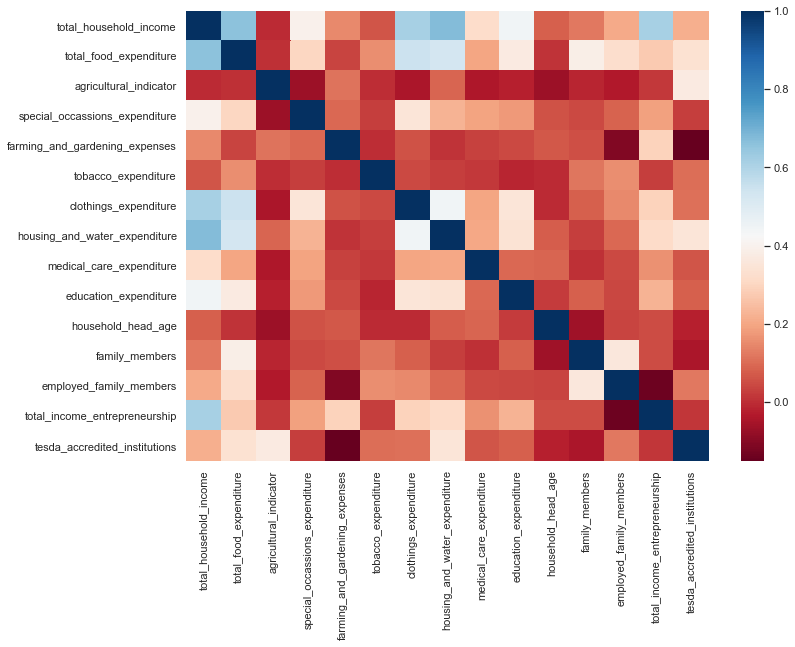

In [89]:
plot_heatmap(non_categorical_df)

### Detecting multicolinearity using VFI

**Variance Factor Inflation (VFI)** detects multicollinearity in regression analysis, and ranges from 1 upwards. It  quantifies how much the variance is inflated by telling you the numerical value in decimal form, what percentage the variance is inflated for each coeffiecient. When significant multicollinearity exists, the variance factor inflation will be huge compared to the other variables in the calculation.

General rule of thumb for interpreting the VFI:
<br><BlockQuote>1 = not correlated<br>
<br>Between 1 and 5 = moderately correlated<br>
<br>Greater than 5 = highly correlated</BlockQuote>

Columns with interpreted high correlation must be removed.

In [90]:
columns_to_drop, columns_vfi_df = get_VFI_score(non_categorical_df,encoded_income_df.columns)

In [91]:
columns_vfi_df

,0
const,24.530738
total_household_income,4.990225
total_food_expenditure,2.777711
agricultural_indicator,1.261124
special_occassions_expenditure,1.244594
farming_and_gardening_expenses,1.188408
tobacco_expenditure,1.054087
clothings_expenditure,1.818564
housing_and_water_expenditure,2.120170
medical_care_expenditure,1.134986


In [92]:
print('Columns to drop: ', columns_to_drop)

Columns to drop:  []


# Building the Models

## Linear Regression

To guarantee that we will have an r-squared of greater than 0.80 for linear regression, we need to find a good randomization in sampling that yields good r-squared values for Train and Test dataset. Thus, we will run the function **get_good_sample_randomization** which will return a random_state value for sampling that gives an r-squared of 80%.

In [93]:
modelLR = LinearRegression()

In [94]:
random_state = get_good_sample_randomization(modelLR,encoded_income_df)

initial:
train score:  0.7928324217126873 
 test score:  0.8446599243043935
Good random state: 3
0.833380647567769 0.812821356026534
Good random state: 4
0.8602075930604859 0.8247759160474653
Good random state: 5
0.81098161270547 0.8674909966194111
Good random state: 7
0.8547235044379563 0.8181700140898887
Good random state: 9
0.8823302784987538 0.8087144937070314
Good random state: 10
0.8915401973752222 0.8109239709195865
Good random state: 11
0.8429291293508117 0.8231049361839787
Good random state: 12
0.854554276508297 0.8471251044133823
Good random state: 13
0.8610462526653204 0.8206903477901852
Good random state: 14
0.8639543922941482 0.82146351051591
Good random state: 25
0.8247835437280837 0.8483492550146332
Good random state: 27
0.8233065922394912 0.8716574542867347
Good random state: 30
0.8555108895689285 0.8427496570998526
Good random state: 32
0.881086375008252 0.8482301956008091
Good random state: 46
0.8949194101808684 0.8568394022116772
Good random state: 47
0.8531429002728

In [95]:
random_state

53

Based on the result above, we wil now create the Linear Regression Model based on the random state (53) returned by the function:

In [96]:
# To identify it from other models, we will append _LR to the X, Y and train/test datasets.
X_LR, Y_LR, x_train_LR, x_test_LR, y_train_LR, y_test_LR = train_test_split_sampling(random_state,encoded_income_df)

modelLR.fit(x_train_LR, y_train_LR.values.flatten())

LinearRegression()

In [97]:
print_score('Linear Regression Model',modelLR,x_train_LR, x_test_LR, y_train_LR, y_test_LR)

Linear Regression Model
Train R-Squared:  0.8703093031683646
Test R-Squared:  0.8868166882432686


### Dealing with Insignificant Variables

In [98]:
# define our input
X2 = sm.add_constant(X_LR)

# create a OLS model
model = sm.OLS(Y_LR, X2)

# fit the data
est = model.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     total_household_income   R-squared:                       0.877
Model:                                OLS   Adj. R-squared:                  0.876
Method:                     Least Squares   F-statistic:                     2422.
Date:                    Thu, 25 Mar 2021   Prob (F-statistic):               0.00
Time:                            21:48:03   Log-Likelihood:            -2.3006e+05
No. Observations:                   17774   AIC:                         4.602e+05
Df Residuals:                       17721   BIC:                         4.606e+05
Df Model:                              52                                         
Covariance Type:                nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                          -9.037e+04   4.98e+04     -1.815      0.069   -1.88e+05    7209.940
total_food_expenditure                             1.2377      0.025     48.584      0.000       1.188       1.288
agricultural_indicator                         -4344.9493   1571.803     -2.764      0.006   -7425.837   -1264.061
special_occassions_expenditure                     1.7046      0.065     26.238      0.000       1.577       1.832
farming_and_gardening_expenses                     0.3181      0.016     20.278      0.000       0.287       0.349
tobacco_expenditure                               -0.3849      0.192     -2.000      0.046      -0.762      -0.008
clothings_expenditure                              5.5627      0.133     41.957      0.000       5.303       5.823
housing_and_water_expenditure                      1.6013      0.021     77.815      0.000       1.561       1.642
medical_care_expenditure                           0.8967      0.040     22.519      0.000       0.819       0.975
education_expenditure                              1.2311      0.043     28.671      0.000       1.147       1.315
household_head_age                               502.1992     72.545      6.923      0.000     360.004     644.395
family_members                                 -8281.5610    465.394    -17.795      0.000   -9193.779   -7369.343
employed_family_members                         2.655e+04    924.258     28.729      0.000    2.47e+04    2.84e+04
total_income_entrepreneurship                      0.7855      0.005    148.719      0.000       0.775       0.796
tesda_accredited_institutions                     -0.5159     38.711     -0.013      0.989     -76.393      75.361
region_CAR                                     -3.921e+04   5259.469     -7.455      0.000   -4.95e+04   -2.89e+04
region_CARAGA                                  -3.805e+04   5002.335     -7.607      0.000   -4.79e+04   -2.82e+04
region_I                                       -2.459e+04   6514.343     -3.774      0.000   -3.74e+04   -1.18e+04
region_II                                      -2.375e+04   4909.159     -4.838      0.000   -3.34e+04   -1.41e+04
region_III                                     -3.983e+04   1.68e+04     -2.367      0.018   -7.28e+04   -6844.905
region_IV-A                                    -3.903e+04   1.42e+04     -2.746      0.006   -6.69e+04   -1.12e+04
region_IV-B                                    -2.569e+04   5610.018     -4.579      0.000   -3.67e+04   -1.47e+04
region_IX                                      -1.102e+04   4248.965     -2.595      0.009   -1.94e+04   -2696.470
region_NCR                                     -2

A p-value higher than 0.05 (> 0.05) is not statistically significant and indicates strong evidence for the null hypothesis, thus we should drop variables with p-value greater than 0.05. 

### Drop insignificant variables and recreating the model

In [99]:
dropped_income_df = encoded_income_df.drop(['tesda_accredited_institutions','region_NCR', 'head_divorced_separated',
                                            'head_married', 'head_single','head_unknown', 'head_widowed','household_type_single_fam',
                                            'household_type_two_more_nonrelated','worker_class_without_pay_in_own_business',
                                            'worker_class_worked_for_private_household','tenure_own_house_rent_free_lot_with_consent',
                                            'tenure_own_house_rent_free_lot_without_consent','tenure_own_house_rent_lot','tenure_owner_house_and_lot',
                                            'tenure_rent_free_house_lot_with_consent','tenure_rent_free_house_lot_without_consent',
                                            'tenure_rent_house_with_lot'], axis=1)
dropped_income_df

,total_household_income,total_food_expenditure,agricultural_indicator,special_occassions_expenditure,farming_and_gardening_expenses,tobacco_expenditure,clothings_expenditure,housing_and_water_expenditure,medical_care_expenditure,education_expenditure,...,region_X,region_XI,region_XII,income_source_other_source_of_income,income_source_wage_salaries,head_sex_male,worker_class_self_employed_without_employee,worker_class_with_pay_in_own_business,worker_class_worked_for_govt,worker_class_worked_for_private
0,480332,117848,0,7200,19370,0,4607,63636,3457,36200,...,0,0,0,0,1,0,0,0,1,0
1,198235,67766,0,1500,0,2132,8230,41370,3520,29300,...,0,0,0,0,1,1,0,0,0,1
2,82785,61609,1,500,0,4525,2735,14340,70,425,...,0,0,0,0,1,1,0,0,0,1
3,107589,78189,0,500,15580,0,1390,16638,60,300,...,0,0,0,0,1,1,0,0,0,0
4,189322,94625,0,1000,18887,0,4620,31122,140,0,...,0,0,0,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43327,246510,109521,2,41000,0,4810,3442,20448,557,3440,...,0,0,0,0,0,1,0,0,0,0
43328,285300,149327,2,1000,0,7800,6945,26580,2104,16260,...,0,0,0,0,0,1,1,0,0,0
43329,285300,149327,2,1000,0,7800,6945,26580,2104,16260,...,0,0,0,0,0,1,1,0,0,0
43330,205590,83441,2,2600,0,0,5090,29208,1691,24000,...,0,0,0,1,0,0,1,0,0,0


Based on the variables to be removed from the model, we can say that no matter what relationship status you are in, (single, married, divorced), regardless of the type of household (single or composite), and even if you are in a worker class (own business or working for another), all of these won't have an effect in predicting the household income. Also in housing tenures, despite owning a house or renting one, with or without lot consent or even owning or renting a lot, it wont be much of a result towards household income.

After removing insignificant variables, let us try to refit the data to see if there are still variables that are insignificant.

In [100]:
X_LR, Y_LR, x_train_LR, x_test_LR, y_train_LR, y_test_LR = train_test_split_sampling(random_state,dropped_income_df)

modelLR.fit(x_train_LR, y_train_LR.values.flatten())

LinearRegression()

In [101]:
# define our input
X2 = sm.add_constant(X_LR)

# create a OLS model
model = sm.OLS(Y_LR, X2)

# fit the data
est = model.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     total_household_income   R-squared:                       0.876
Model:                                OLS   Adj. R-squared:                  0.876
Method:                     Least Squares   F-statistic:                     3586.
Date:                    Thu, 25 Mar 2021   Prob (F-statistic):               0.00
Time:                            21:48:03   Log-Likelihood:            -2.3009e+05
No. Observations:                   17774   AIC:                         4.603e+05
Df Residuals:                       17738   BIC:                         4.605e+05
Df Model:                              35                                         
Covariance Type:                nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                       -8.691e+04   5781.590    -15.032      0.000   -9.82e+04   -7.56e+04
total_food_expenditure                          1.2059      0.025     48.871      0.000       1.158       1.254
agricultural_indicator                      -8502.3304   1412.200     -6.021      0.000   -1.13e+04   -5734.280
special_occassions_expenditure                  1.7105      0.065     26.347      0.000       1.583       1.838
farming_and_gardening_expenses                  0.3322      0.015     21.544      0.000       0.302       0.362
tobacco_expenditure                            -0.4185      0.192     -2.175      0.030      -0.796      -0.041
clothings_expenditure                           5.6235      0.132     42.580      0.000       5.365       5.882
housing_and_water_expenditure                   1.5889      0.020     78.352      0.000       1.549       1.629
medical_care_expenditure                        0.8960      0.040     22.507      0.000       0.818       0.974
education_expenditure                           1.2453      0.043     29.072      0.000       1.161       1.329
household_head_age                            478.9312     67.408      7.105      0.000     346.806     611.057
family_members                              -7370.5188    420.070    -17.546      0.000   -8193.897   -6547.140
employed_family_members                      2.654e+04    914.941     29.002      0.000    2.47e+04    2.83e+04
total_income_entrepreneurship                   0.7841      0.005    148.479      0.000       0.774       0.794
region_CAR                                  -2.557e+04   4591.195     -5.569      0.000   -3.46e+04   -1.66e+04
region_CARAGA                               -2.516e+04   4476.910     -5.619      0.000   -3.39e+04   -1.64e+04
region_I                                    -1.137e+04   4346.281     -2.616      0.009   -1.99e+04   -2849.152
region_II                                   -9085.6925   4260.580     -2.133      0.033   -1.74e+04    -734.539
region_III                                  -2.515e+04   3941.549     -6.381      0.000   -3.29e+04   -1.74e+04
region_IV-A                                 -2.478e+04   3669.260     -6.753      0.000    -3.2e+04   -1.76e+04
region_IV-B                                 -1.282e+04   4998.820     -2.564      0.010   -2.26e+04   -3019.377
region_IX                                    2415.3053   3545.835      0.681      0.496   -4534.879    9365.489
region_V                                    -1.962e+04   4110.126     -4.773      0.000   -2.77e+04   -1.16e+04
region_VI                                   -2.534e+04   3944.433     -6.425      0.000   -3.31e+04   -1.76e+04
region_VII     

There are still 2 variables that we need to drop since our goal is to remove all variables that have p-value greater than 0.05. 

In [102]:
redropped_income_df = dropped_income_df.drop(['region_IX', 'region_X'], axis=1)
redropped_income_df

,total_household_income,total_food_expenditure,agricultural_indicator,special_occassions_expenditure,farming_and_gardening_expenses,tobacco_expenditure,clothings_expenditure,housing_and_water_expenditure,medical_care_expenditure,education_expenditure,...,region_VIII,region_XI,region_XII,income_source_other_source_of_income,income_source_wage_salaries,head_sex_male,worker_class_self_employed_without_employee,worker_class_with_pay_in_own_business,worker_class_worked_for_govt,worker_class_worked_for_private
0,480332,117848,0,7200,19370,0,4607,63636,3457,36200,...,0,0,0,0,1,0,0,0,1,0
1,198235,67766,0,1500,0,2132,8230,41370,3520,29300,...,0,0,0,0,1,1,0,0,0,1
2,82785,61609,1,500,0,4525,2735,14340,70,425,...,0,0,0,0,1,1,0,0,0,1
3,107589,78189,0,500,15580,0,1390,16638,60,300,...,0,0,0,0,1,1,0,0,0,0
4,189322,94625,0,1000,18887,0,4620,31122,140,0,...,0,0,0,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43327,246510,109521,2,41000,0,4810,3442,20448,557,3440,...,0,0,0,0,0,1,0,0,0,0
43328,285300,149327,2,1000,0,7800,6945,26580,2104,16260,...,0,0,0,0,0,1,1,0,0,0
43329,285300,149327,2,1000,0,7800,6945,26580,2104,16260,...,0,0,0,0,0,1,1,0,0,0
43330,205590,83441,2,2600,0,0,5090,29208,1691,24000,...,0,0,0,1,0,0,1,0,0,0


In [103]:
X_LR, Y_LR, x_train_LR, x_test_LR, y_train_LR, y_test_LR = train_test_split_sampling(random_state,redropped_income_df)

modelLR.fit(x_train_LR, y_train_LR.values.flatten())

LinearRegression()

In [104]:
# define our input
X2 = sm.add_constant(X_LR)

# create a OLS model
model = sm.OLS(Y_LR, X2)

# fit the data
est = model.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     total_household_income   R-squared:                       0.876
Model:                                OLS   Adj. R-squared:                  0.876
Method:                     Least Squares   F-statistic:                     3804.
Date:                    Thu, 25 Mar 2021   Prob (F-statistic):               0.00
Time:                            21:48:04   Log-Likelihood:            -2.3009e+05
No. Observations:                   17774   AIC:                         4.603e+05
Df Residuals:                       17740   BIC:                         4.605e+05
Df Model:                              33                                         
Covariance Type:                nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                       -8.581e+04   5385.802    -15.933      0.000   -9.64e+04   -7.53e+04
total_food_expenditure                          1.2046      0.024     49.518      0.000       1.157       1.252
agricultural_indicator                      -8725.8431   1311.955     -6.651      0.000   -1.13e+04   -6154.283
special_occassions_expenditure                  1.7117      0.065     26.400      0.000       1.585       1.839
farming_and_gardening_expenses                  0.3325      0.015     21.575      0.000       0.302       0.363
tobacco_expenditure                            -0.4203      0.192     -2.185      0.029      -0.797      -0.043
clothings_expenditure                           5.6280      0.132     42.755      0.000       5.370       5.886
housing_and_water_expenditure                   1.5871      0.020     78.996      0.000       1.548       1.626
medical_care_expenditure                        0.8957      0.040     22.505      0.000       0.818       0.974
education_expenditure                           1.2453      0.043     29.097      0.000       1.161       1.329
household_head_age                            480.3957     67.305      7.138      0.000     348.472     612.319
family_members                              -7379.6599    419.809    -17.579      0.000   -8202.527   -6556.793
employed_family_members                      2.658e+04    909.576     29.224      0.000    2.48e+04    2.84e+04
total_income_entrepreneurship                   0.7842      0.005    148.591      0.000       0.774       0.795
region_CAR                                  -2.655e+04   4177.169     -6.356      0.000   -3.47e+04   -1.84e+04
region_CARAGA                               -2.617e+04   4019.673     -6.511      0.000   -3.41e+04   -1.83e+04
region_I                                    -1.241e+04   3852.818     -3.220      0.001      -2e+04   -4854.323
region_II                                   -1.009e+04   3806.652     -2.649      0.008   -1.75e+04   -2623.869
region_III                                  -2.613e+04   3451.691     -7.570      0.000   -3.29e+04   -1.94e+04
region_IV-A                                 -2.576e+04   3134.641     -8.216      0.000   -3.19e+04   -1.96e+04
region_IV-B                                 -1.382e+04   4613.118     -2.995      0.003   -2.29e+04   -4774.849
region_V                                    -2.063e+04   3611.250     -5.713      0.000   -2.77e+04   -1.36e+04
region_VI                                   -2.635e+04   3429.448     -7.683      0.000   -3.31e+04   -1.96e+04
region_VII                                  -1.623e+04   3615.624     -4.488      0.000   -2.33e+04   -9140.554
region_VIII    

Looking at the output, we now see that all of the independent variables are significant. Now let's grab the coefficient and the intercept of our model.

In [105]:
print("The intercept for our model:", modelLR.intercept_)
print("The coefficients for our model:")
coeff_parameter = pd.DataFrame(modelLR.coef_,X_LR.columns,columns=['Coefficient'])
coeff_parameter

The intercept for our model: -80724.68959020407
The coefficients for our model:


,Coefficient
total_food_expenditure,1.153445
agricultural_indicator,-6935.541637
special_occassions_expenditure,1.693049
farming_and_gardening_expenses,0.303110
tobacco_expenditure,-0.273241
clothings_expenditure,5.622308
housing_and_water_expenditure,1.572794
medical_care_expenditure,0.895441
education_expenditure,1.121966
household_head_age,439.263066


### Linear Model Regression Measurement of Errors

In [106]:
y_pred_LR = modelLR.predict(x_test_LR)
print_errors('Linear Regression Model',y_pred_LR,y_test_LR)

Linear Regression Model
Mean Squared Error (MSE):  11134885647.90561
Mean Absolute Error (MAE):  56411.657485605625
Root Mean Squared Error (RMSE):  105521.9676081981



## Random Forest Regressor

After creating the linear regression model, we wondered how  We are how will the dataset perform on other models, such as a Random Forest Model? Will the result be similar or different to the linear regression model?

We sampled the data frame because **higher sample size requires more processing power and time** and also reduces the r2 of the model. This will also help us find a sampling that is less likely to be overfitted or underfitted.

In [107]:
# instantiate models
modelRF_regression = RandomForestRegressor(max_depth=5,random_state=1)

In [108]:
random_state = get_good_sample_randomization(modelRF_regression,encoded_income_df)

initial:
train score:  0.8264541777003221 
 test score:  0.8053646708210361
Good random state: 10
0.8247352998339526 0.8377148163281233
Good random state: 17
0.8012287525289552 0.8409985280846299
Good random state: 35
0.8064292311922658 0.830177178801406
Good random state: 43
0.8111959132665238 0.8379416435745886
Good random state: 46
0.8309397262719349 0.8288691633404985
Good random state: 50
0.8173442019250704 0.85170208609686
Good random state: 87
0.8325097955302247 0.8384833431110946


In [109]:
random_state

87

After running the randomization function in our test notebook, **the best randomization of the sample that yields 80% r-squared is 87** and is also consistent for both test and train dataset. Thus, we will use the random state of 87.

In [110]:
# To separate it from other models we will append _regressor
X_regressor,Y_regressor,x_train_regressor, x_test_regressor, y_train_regressor, y_test_regressor = train_test_split_sampling(random_state = random_state, df = encoded_income_df)
modelRF_regression.fit(x_train_regressor, y_train_regressor.values.flatten())

RandomForestRegressor(max_depth=5, random_state=1)

In [111]:
print_score('Random Forest Regressor Model',modelRF_regression,x_train_regressor, x_test_regressor, y_train_regressor, y_test_regressor)

Random Forest Regressor Model
Train R-Squared:  0.8384833431110946
Test R-Squared:  0.8325097955302247


### Determining Random Forest Regressor Model Accuracy

In order for us to examined how our data fits the model, we will take predicted value and compare them to our actual value these will be our residuals. From here we can calculate a few metrics to check how well our model fits the data.

In [112]:
y_pred_regressor = modelRF_regression.predict(x_test_regressor)

In [113]:
print_errors("Random Forest Regression Model", y_pred_regressor, y_test_regressor)

Random Forest Regression Model
Mean Squared Error (MSE):  13224166549.5167
Mean Absolute Error (MAE):  63056.677685710085
Root Mean Squared Error (RMSE):  114996.37624515261



### Visualization of a Tree of the Random Forest
Since there are around 100 estimators/trees in the randome forest regressor model, we will just select the tree in index 5.

In [114]:
tree = modelRF_regression.estimators_[5]
visualize_tree(tree,'regressor',X_regressor)

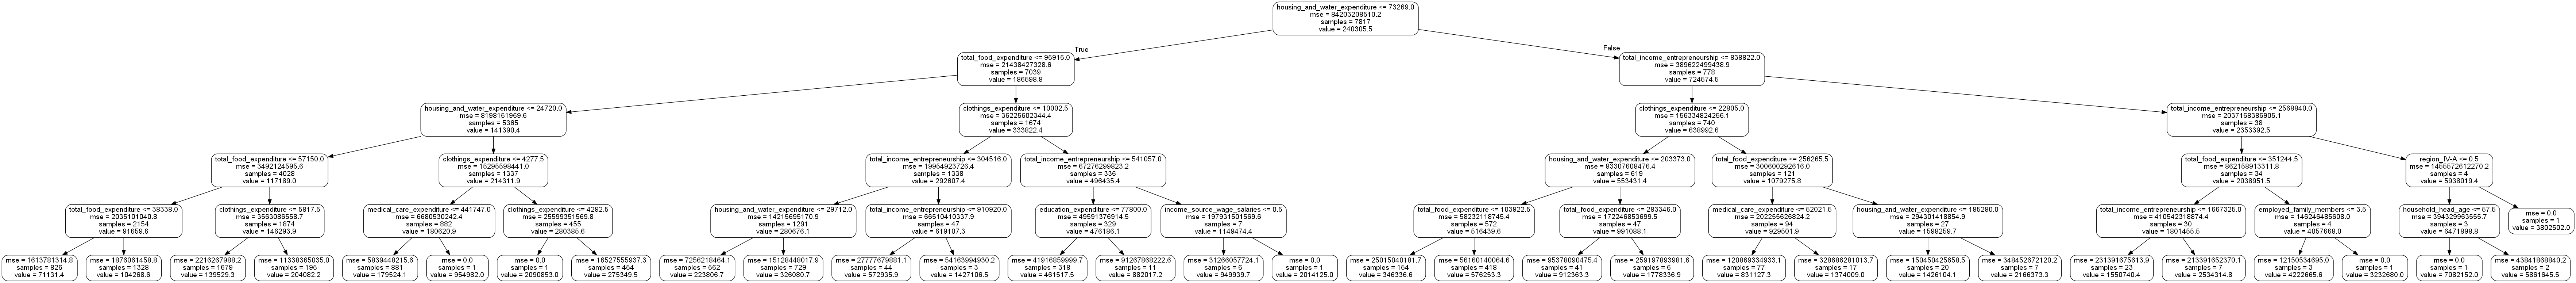

In [115]:
Image(filename='regressor.png') 

In [116]:
print_important_variables(model = modelRF_regression,X = X_regressor)

housing_and_water_expenditure Importance: 0.43
total_income_entrepreneurship Importance: 0.3
total_food_expenditure Importance: 0.18
clothings_expenditure Importance: 0.06
household_head_age   Importance: 0.01
agricultural_indicator Importance: 0.0
special_occassions_expenditure Importance: 0.0
farming_and_gardening_expenses Importance: 0.0
tobacco_expenditure  Importance: 0.0
medical_care_expenditure Importance: 0.0
education_expenditure Importance: 0.0
family_members       Importance: 0.0
employed_family_members Importance: 0.0
tesda_accredited_institutions Importance: 0.0
region_CAR           Importance: 0.0
region_CARAGA        Importance: 0.0
region_I             Importance: 0.0
region_II            Importance: 0.0
region_III           Importance: 0.0
region_IV-A          Importance: 0.0
region_IV-B          Importance: 0.0
region_IX            Importance: 0.0
region_NCR           Importance: 0.0
region_V             Importance: 0.0
region_VI            Importance: 0.0
region_VII 

## Random Forest Classifier
Since income can be classified, it is also insightful if we include a classifier model for the random forest. Here we **classified** the income using the [ABS-CBN news article](https://news.abs-cbn.com/news/09/17/20/who-are-identified-rich-poor-govt-shows-income-class-brackets-in-ph).<br><br>

**Philippines Monthly Income Classification**:<br><br>
Poor: Below P10,957<br>
Low-income but not poor: P10,957 to P21,914<br>
Lower middle: P21,914 to P43,828<br>
Middle: P43,828 to P76,669<br>
Upper middle: P76,669 to P131,484<br>
Upper middle but not rich: P131,483 to P219,140<br>
Rich: P219,140 and above<br>

As for the state, we will also use the same **random_state value of 87** from the random forest regressor model.

In [139]:
sampled_income_df = encoded_income_df.sample(n=len(encoded_income_df.index),random_state=random_state)

In [140]:
# Assign columns to X and Y
X_classifier = sampled_income_df.drop(['total_household_income'], axis = 1)
Y_classifier = sampled_income_df[['total_household_income']]

In [141]:
# To be used for the classification of the income values
conditions = [
    Y_classifier.values > 219140,
    Y_classifier.values > 131483,
    Y_classifier.values > 76669,
    Y_classifier.values > 43828,
    Y_classifier.values > 21914,
    Y_classifier.values > 10957,
    Y_classifier.values > 0,
]
choices = [
    'rich', 
    'upper_middle_not_rich', 
    'upper_middle', 
    'middle', 
    'lower_middle', 
    'low_income_not_poor',
    'poor'
]

In [142]:
y_classified = pd.DataFrame(np.select(conditions, choices, default='zero'), index=Y_classifier.index,columns=Y_classifier.columns)

In [143]:
y_classified.total_household_income.unique()

array(['upper_middle_not_rich', 'rich', 'middle', 'upper_middle',
       'lower_middle', 'low_income_not_poor'], dtype=object)

In [144]:
Y_classifier = y_classified

### Creating a train test split after classifying the Income

In [145]:
# Split X and y into X_
x_train_classifier, x_test_classifier, y_train_classifier, y_test_classifier = train_test_split(X_classifier, Y_classifier, test_size=0.30, random_state=1)

In [146]:
modelRF_classifier = RandomForestClassifier(max_depth=5,random_state=1)

In [147]:
modelRF_classifier.fit(x_train_classifier, y_train_classifier.values.flatten())
print_score("Random Forest Classifier Model", modelRF_classifier,x_train_classifier, x_test_classifier, y_train_classifier, y_test_classifier)

Random Forest Classifier Model
Train R-Squared:  0.6841343835396239
Test R-Squared:  0.6724800750117206


In [148]:
tree = modelRF_classifier.estimators_[5]
visualize_tree(tree,'classifier',X_classifier,choices)

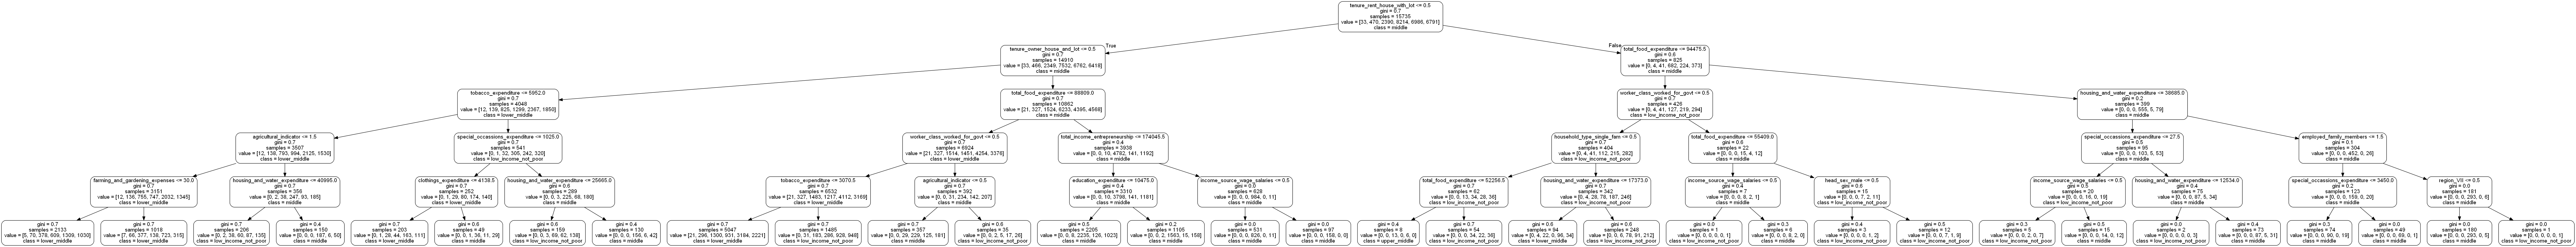

In [149]:
Image(filename='classifier.png') 

In [150]:
# Get feature importances
print_important_variables(modelRF_classifier,X_classifier)

total_food_expenditure Importance: 0.28
housing_and_water_expenditure Importance: 0.25
clothings_expenditure Importance: 0.12
medical_care_expenditure Importance: 0.07
total_income_entrepreneurship Importance: 0.07
special_occassions_expenditure Importance: 0.05
education_expenditure Importance: 0.05
employed_family_members Importance: 0.02
tesda_accredited_institutions Importance: 0.02
agricultural_indicator Importance: 0.01
farming_and_gardening_expenses Importance: 0.01
family_members       Importance: 0.01
region_NCR           Importance: 0.01
household_type_single_fam Importance: 0.01
tobacco_expenditure  Importance: 0.0
household_head_age   Importance: 0.0
region_CAR           Importance: 0.0
region_CARAGA        Importance: 0.0
region_I             Importance: 0.0
region_II            Importance: 0.0
region_III           Importance: 0.0
region_IV-A          Importance: 0.0
region_IV-B          Importance: 0.0
region_IX            Importance: 0.0
region_V             Importance: 

### Determining Random Forest Classifier Model Accuracy
To do this, we will create a confusion matrix to visualize the predictions.

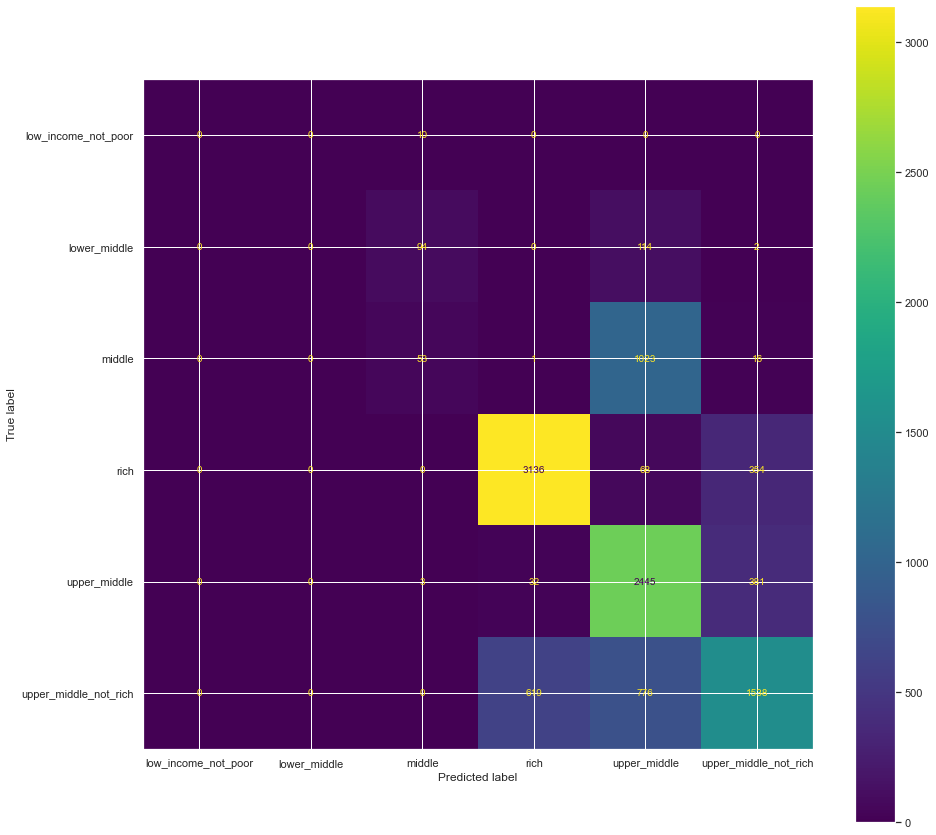

In [151]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(modelRF_classifier, x_test_classifier, y_test_classifier, ax=ax)  
plt.show()

In [152]:
y_pred_classifier = modelRF_classifier.predict(x_test_classifier)

In [153]:
accuracy_score(y_test_classifier, y_pred_classifier)

0.6724800750117206

## Comparing the 3 Models

After creating the three models, we will now compare them so that we can get more insight from the dataset:

In [154]:
print_score('Linear Regression Model',modelLR,x_train_LR, x_test_LR, y_train_LR, y_test_LR)

Linear Regression Model
Train R-Squared:  0.8697098588775578
Test R-Squared:  0.8867126541026958


In [155]:
print_score('Random Forest Regressor Model',modelRF_regression,x_train_regressor, x_test_regressor, y_train_regressor, y_test_regressor)

Random Forest Regressor Model
Train R-Squared:  0.8384833431110946
Test R-Squared:  0.8325097955302247


In [156]:
print_score("Random Forest Classifier Model", modelRF_classifier,x_train_classifier, x_test_classifier, y_train_classifier, y_test_classifier)

Random Forest Classifier Model
Train R-Squared:  0.6841343835396239
Test R-Squared:  0.6724800750117206


Out of the three models, **Linear Regression has the highest r-squared** while **Random Forest Classifier has the lowest r-squared**. This means that **Linear Regression Model best** fits the dataset.

In [157]:
print_errors("Random Forest Regression Model",y_pred_LR,y_test_LR)

Random Forest Regression Model
Mean Squared Error (MSE):  11134885647.90561
Mean Absolute Error (MAE):  56411.657485605625
Root Mean Squared Error (RMSE):  105521.9676081981



In [158]:
print_errors("Random Forest Regression Model", y_pred_regressor, y_test_regressor)

Random Forest Regression Model
Mean Squared Error (MSE):  13224166549.5167
Mean Absolute Error (MAE):  63056.677685710085
Root Mean Squared Error (RMSE):  114996.37624515261



Comparing the Regressor Model for Random Forest and the Linear Regression Model, **Linear Regression Model** has lower values for measurement of errors. This means that the Linear Regression Model is more accurate in its prediction.

In [159]:
accuracy_score(y_test_classifier, y_pred_classifier)

0.6724800750117206

On the other hand, the **random forest classifier** can only predict **67% of the data correctly** which is moderately accurate.

In [138]:
%%html
<style>
table {float:left}
</style>

### Feature Importance on Random Forest Models

Meanwhile, the **features that are considered important for the Random Forest Regressor model** are:

| Variable | Importance |
| --- | --- |
|housing_and_water_expenditure| 0.43|
|total_income_entrepreneurship |0.3|
|total_food_expenditure| 0.18|
|clothings_expenditure| 0.06|
|household_head_age| 0.01|

Meanwhile, the **features that are considered important for the Random Forest Classifier model** are:

| Variable | Importance |
| --- | --- |
|total_food_expenditure| 0.28|
|housing_and_water_expenditure| 0.25|
|clothings_expenditure| 0.12|
|medical_care_expenditure| 0.07|
|total_income_entrepreneurship| 0.07|
|special_occassions_expenditure| 0.05|
|education_expenditure| 0.05|
|employed_family_members|0.02|
|tesda_accredited_institutions| 0.02|
|agricultural_indicator| 0.01|
|farming_and_gardening_expenses| 0.01|
|family_members|0.01|
|region_NCR|0.01|
|household_type_single_fam|0.01|

# Interpretation 

### Random Forest Models

<font color=blue>**Both models consider the following features important:**</font>
- housing_and_water_expenditure
- total_income_entrepreneurship
- total_food_expenditure
- clothings_expenditure

Since both models consider the above features important, this means that these features are **good indicators** of the total household income of a family.

The number of TESDA accredited institutions per region has only an importance value of 0.02 in the classifier model and is not considered as important in the regressor model, this means that it is not the best indicator of the total household income of a family.

From the two random forest models, the **regressor model fits the household income and expenditure dataset better** than the classifier model.

### Linear Regression

#### Multiple Linear Regression Equation
**total_household_income** = 
<br> -80724.68959029266 + 1.15(**total_food_expenditure**) - 6935.54(**agricultural_indicator**) 
<br> + 1.69(**special_occassions_expenditure**) + 0.30(**farming_and_gardening_expenses**) - 0.27(**tobacco_expenditure**)
<br> + 5.62(**clothings_expenditure**) + 1.57(**housing_and_water_expenditure**) + 0.90(**medical_care_expenditure**)
<br> + 1.12(**education_expenditure**) + 439.26(**household_head_age**) - 7356.65(**family_members**) + 27594.36(**employed_family_members**)<br> + 0.81(**total_income_entrepreneurship**) - 30458.83(**region_CAR**) - 29312.85(**region_CARAGA**) - 13032.43(**region_I**)
<br> - 13656.38(**region_II**) - 25622.01(**region_III**) - 24190.76(**region_IV-A**) - 11381.36(**region_IV-B**)
<br> - 19617.12(**region_V**) - 26765.93(**region_VI**) - 15402.01(**region_VII**) - 13824.16(**region_VIII**)
<br> - 15224.30(**region_XI**) - 25020.19(**region_XII**) + 52277.60(**income_source_other_source_of_income**)
<br> + 71450.91(**income_source_wage_salaries**) - 7338.06(**head_sex_male**) + 14416.68(**worker_class_self_employed_without_employee**)
<br> + 292849.43(**worker_class_with_pay_in_own_business**) + 76858.80(**worker_class_worked_for_govt**)
+14213.01(**worker_class_worked_for_private**)</BLOCKQUOTE><br>

**Total household income has a positive relationship with:**
- total_food_expenditure
- special_occassions_expenditure
- farming_and_gardening_expenses
- clothings_expenditure
- housing_and_water_expenditure
- medical_care_expenditure
- education_expenditure
- household_head_age
- employed_family_members
- total_income_entrepreneurship
- income_source_other_source_of_income
- income_source_wage_salaries
- worker_class_self_employed_without_employee
- worker_class_with_pay_in_own_business
- worker_class_worked_for_govt
- worker_class_worked_for_private

**Total household income has a negative relationship with:**
- agricultural_indicator
- tobacco_expenditure
- family_members
- region_CAR	
- region_CARAGA	
- region_I
- region_II
- region_III
- region_IV-A
- region_IV-B
- region_V	
- region_VI	
- region_VII
- region_VIII
- region_XI
- region_XII
- head_sex_male

**Efficiency/Accuracy of the Model**
- The R squared value is 0.88, which means that **88% of the data are explained by the regression model.**
- Using the Root Mean Squared Error (RMSE) value, the predicted total household income can be off by +-105521.97.

## Conclusion

Based on the results, the **linear regression model** should be used for predicting total household income. Based on the linear regression model, we can say that the **region where the household is located has negative relationship with the the total household income**. The analysis also states that the number of employed members of the family, have or have not, the income source coming from wage/salaries, can affect the total household income as well. We also found out that there is an **insignificant correlation between the availability of TESDA accredited institutions per region with the total income of a household** in the Philippines.

**Other worth noting results:**
- A household head working for the **government** has an increase of 76,858.80 in total household income whie a private worker has an increase of 14,213.01 in total household income
- With every peso spent on **education**, the total household income increases by 1.12 pesos.
- If the household head is **male**, the total household income increases by 7,338.06 pesos.
- **Working for your own business with pay** increases the total household income by 292,849.43 pesos.